In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
train_dataset = torchvision.datasets.FashionMNIST(root='.', train=True, transform=transforms.ToTensor(), download=True)

In [3]:
train_dataset.data.max()    # color의 마지막 Black = 255

tensor(255, dtype=torch.uint8)

In [4]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [5]:
train_dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [6]:
test_dataset = torchvision.datasets.FashionMNIST(
    root='.', train=False, transform=transforms.ToTensor(), download=True)
test_dataset.data.shape

torch.Size([10000, 28, 28])

In [7]:
# number of classes
K = len(set(train_dataset.targets.numpy()))
print("number of classes:", K)

number of classes: 10


In [8]:
# Define the model
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            nn.ReLU()
        )
        # http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html
        # "No zero padding, non-unit strides"
        # https://pytorch.org/docs/stable/nn.html
        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(128*2*2, 512),    # I need to calculate by myself
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512,K)            # K
        )
        
    def forward(self, X):
        out = self.conv_layers(X)
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)
        return out

In [9]:
# Calculation for Flatten dimension

# Output dimensions = floor[ (Input + (2xpadding) - (kernel_size - 1) - 1) / stride + 1 ]
# H & W 를 각각 계산하여야 함 그래서 128 * 2 (H) * 2 (W)

# First Layer : input = 28 * 28 *1 --> kernel_size = 3, stride = 2
input = 28

Hout_layer1 = np.floor((input - (3-1) -1)/2 + 1)
print(Hout_layer1)
input = Hout_layer1

# Second Layer : kernel_size = 3, stride = 2
Hout_layer2 = np.floor((input - (3-1) -1)/2 + 1)
print(Hout_layer2)
input = Hout_layer2

# Third Layer : kernel_size = 3, stride = 2
Hout_layer3 = np.floor((input - (3-1) -1)/2 + 1)
print(Hout_layer3)                                   # 2 x 2 x 128 (final filter channel)

13.0
6.0
2.0


In [10]:
# Calculation for the number of parameters

# The Number of First Layer Parameters

# First Layer : filter_channel = 32, kernel_size = 3 x 3 x 1, b (절편) = 32
param_layer1 = (3 * 3 * 1) * 32 + 32
print(param_layer1)

# Secon Layer : filter_channel = 64, kernel_size = 3 x 3 x 32, b (절편) = 64
param_layer2 = (3 * 3 * 32) * 64 + 64
print(param_layer2)

# Third Layer : filter_channel = 64, kernel_size = 3 x 3 x 64, b (절편) = 64
param_layer3 = (3 * 3 * 64) * 128 + 128
print(param_layer3)

320
18496
73856


In [11]:
# Instantiate the model
model = CNN(K)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [13]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [14]:
# Data loader
# Useful because it automatically generates batches in the training loop
# and takes care of shuffling

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [15]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    # Stuff to store
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for it in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)
        
            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
    
        # Get train loss and test loss
        train_loss = np.mean(train_loss)   # a little misleading

        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')
        
    return train_losses, test_losses

In [16]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=15)

Epoch 1/15, Train Loss: 0.6569, Test Loss: 0.4957, Duration: 0:00:07.156387
Epoch 2/15, Train Loss: 0.4364, Test Loss: 0.4211, Duration: 0:00:06.158604
Epoch 3/15, Train Loss: 0.3715, Test Loss: 0.3822, Duration: 0:00:06.072158
Epoch 4/15, Train Loss: 0.3346, Test Loss: 0.3635, Duration: 0:00:06.080234
Epoch 5/15, Train Loss: 0.3064, Test Loss: 0.3434, Duration: 0:00:06.043820
Epoch 6/15, Train Loss: 0.2843, Test Loss: 0.3339, Duration: 0:00:06.057195
Epoch 7/15, Train Loss: 0.2662, Test Loss: 0.3196, Duration: 0:00:06.085264
Epoch 8/15, Train Loss: 0.2493, Test Loss: 0.3177, Duration: 0:00:06.213088
Epoch 9/15, Train Loss: 0.2333, Test Loss: 0.3185, Duration: 0:00:06.040837
Epoch 10/15, Train Loss: 0.2209, Test Loss: 0.3000, Duration: 0:00:06.046825
Epoch 11/15, Train Loss: 0.2061, Test Loss: 0.3171, Duration: 0:00:06.033584
Epoch 12/15, Train Loss: 0.1955, Test Loss: 0.3015, Duration: 0:00:06.050468
Epoch 13/15, Train Loss: 0.1857, Test Loss: 0.3331, Duration: 0:00:06.049201
Epoch 14

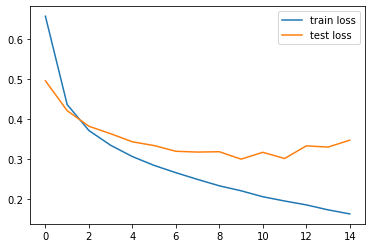

In [17]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [18]:
# Accuracy

n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)
    
    # Forward pass
    outputs = model(inputs)
    #print(outputs.shape)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)      # _ : result value, predictions : max로 선택된 Digit index (logit function)
    # print(_, predictions)
    
    # update counts
    n_correct += (predictions == targets).sum().item()   # item : sum까지만 하면 출력이 tensor로 표현되므로 합산만 뽑아냄
    n_total += targets.shape[0]
    
train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)
    
    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)      # _ : result value, predictions : max로 선택된 Digit index (logit function)
    
    # update counts
    n_correct += (predictions == targets).sum().item()   # item : sum까지만 하면 출력이 tensor로 표현되므로 합산만 뽑아냄
    n_total += targets.shape[0]
    
test_acc = n_correct / n_total
print(f'Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}')

Train acc: 0.9385, Test acc: 0.8906


In [19]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    if normalize:
        cm = dm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)    # color 부여
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt),
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
  # Do these results make sense?
  # It's easy to confuse 9 <--> 4, 9 <--> 7, 2 <--> 7, etc.

Confusion matrix, without normalization
[[770   1  23  18   6   1 175   0   6   0]
 [  2 975   1  12   2   0   6   0   2   0]
 [ 10   0 775  10 103   0 101   0   1   0]
 [ 10  11  15 866  54   2  39   0   3   0]
 [  0   0  24  15 910   0  51   0   0   0]
 [  1   0   0   0   0 972   0  17   1   9]
 [ 65   2  44  21 130   0 731   1   6   0]
 [  0   0   0   0   0  17   0 955   0  28]
 [  5   1   5   2   5   6  12   3 961   0]
 [  0   0   0   0   0   3   1  36   0 960]]


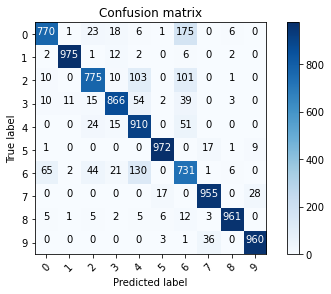

In [24]:
# get all predictions in an array and plot confusion matrix

x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])                   # p_test : prediction test

for inputs, targets in test_loader:
    # move data to GPU
    inputs = inputs.to(device)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    _, predictions = torch.max(outputs, 1)  
    
    # update p_test
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))   # concatenate : 여러개의 array를 붙임
    #print(p_test)
    #p_test2 = np.array(predictions.cpu().numpy())    
    # p_test2와 같이 array를 바로 감쌀수도 있으나, 그러면 concatenate 처럼 For loop 동안에 발생한 모든 array를 붙일 수 없음
    #print(p_test2)
    
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [20]:
# Label mapping
labels = '''T-shirt/top = 0
Trouser = 1
Pullover = 2
Dress = 3
Coat = 4
Sandal = 5
Shirt = 6
Sneaker = 7
Bag =8
Ankly boot = 9'''.split("\n")

In [21]:
labels

['T-shirt/top = 0',
 'Trouser = 1',
 'Pullover = 2',
 'Dress = 3',
 'Coat = 4',
 'Sandal = 5',
 'Shirt = 6',
 'Sneaker = 7',
 'Bag =8',
 'Ankly boot = 9']

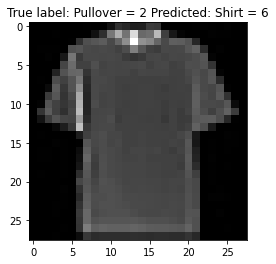

In [25]:
# Show some misclassified examples
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title('True label: %s Predicted: %s' % (labels[y_test[i]], labels[int(p_test[i])]));